#ejercicios
## teoría
1. ¿Qué problemas éticos existen al usar modelos predictivos en medicina?

    a. ¿Pueden ayudar a los médicos a hacer una diagnóstico final?

    b. Si no entrenamos en datos de niños, ¿es justo que solo mejoramos la salud para adultos?

    c. Si ML ayuda a algunos pero lastima a otros, ¿debemos implementarlo?

2. ¿Cuáles son los requisitos de COFEPRIS para implemntar nuevo software para ECGs?

## programación
1. ¿Puedes mejorar la predición (disminuir falso positivos y falso negativos) del modelo?
    
    a. mejora los [hiperpárametros](https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b)

    b. cambia a orto modelo [classifier (e.g. Random Forest, Decision tree, SVD, escribe tu propios thresholds)](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) en lugar de MLPClassifier

    c. predicte con canales diferentes/adicionales (yo solo uso un canal)

2. Predice otras enfermedades en lugar de myocardial infarction o predice si un paciente es saludable o no.

In [1]:
%pip install wfdb
%pip install --upgrade keras
%pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation:

In [2]:
from wfdb import io, plot
import wfdb
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input, LSTM
from keras.callbacks import ModelCheckpoint
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import neurokit2 as nk
import time
import keras
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Subir datos

In [3]:
def comments_to_dict(comments):
    key_value_pairs = [comment.split(':') for comment in comments]
    return {pair[0]: pair[1] for pair in key_value_pairs}

def record_to_row(record, patient_id):
    row = {}
    row['patient'] = patient_id
    row['name'] = record.record_name
    row['label'] = comments_to_dict(record.comments)['Reason for admission'][1:]
    row['signals'] = record.p_signal
    row['signal_length'] = record.sig_len
    channels = record.sig_name
    signals = record.p_signal.transpose()

    row['channels'] = channels

    for channel, signal in zip(channels, signals):
        row[channel] = signal

    return row

record_names = io.get_record_list('ptbdb')
record_names[:5]

['patient001/s0010_re',
 'patient001/s0014lre',
 'patient001/s0016lre',
 'patient002/s0015lre',
 'patient003/s0017lre']

In [4]:
os.chdir("drive/MyDrive/Miscellaneous/Clubes de Ciencia 2025/Programacion/PTB-Diagnostic-Ecg/") # cambia esto a la directoria de la carpeta de tus datos

In [5]:
records = []
for record_name in tqdm(record_names):
    record = wfdb.rdrecord(record_name=os.path.join('ptb-diagnostic-ecg-database-1.0.0', record_name))
    label = comments_to_dict(record.comments)['Reason for admission'][1:]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient, 'signal_length':signal_length})

channels = record.sig_name
df_records = pd.DataFrame(records)
df_records

  0%|          | 0/549 [00:00<?, ?it/s]

,name,label,patient,signal_length
0,patient001/s0010_re,Myocardial infarction,patient001,38400
1,patient001/s0014lre,Myocardial infarction,patient001,115200
2,patient001/s0016lre,Myocardial infarction,patient001,115200
3,patient002/s0015lre,Myocardial infarction,patient002,115200
4,patient003/s0017lre,Myocardial infarction,patient003,115200
...,...,...,...,...
544,patient292/s0555_re,Myocardial infarction,patient292,120012
545,patient292/s0556_re,Myocardial infarction,patient292,120012
546,patient293/s0557_re,Myocardial infarction,patient293,120012
547,patient293/s0558_re,Myocardial infarction,patient293,120012


In [6]:
labels = df_records['label'].unique()
df_records['label'].value_counts()

,count
label,
Myocardial infarction,368
Healthy control,80
n/a,27
Bundle branch block,17
Cardiomyopathy,17
Dysrhythmia,16
Hypertrophy,7
Valvular heart disease,6
Myocarditis,4


# selecionar datos de training y testing

In [7]:
selected_labels = [
    'Healthy control',
    'Myocardial infarction'
    ]
df_selected = df_records.loc[df_records['label'].isin(selected_labels)]
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}
label_map

{'Healthy control': 0, 'Myocardial infarction': 1}

In [8]:
test_patients = []
train_patients = []
test_size = 0.2
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])

In [9]:
def make_set(df_data, channels, label_map, record_id, window_size=2048):

    dataX = np.zeros((len(df_data), len(channels), window_size))
    dataY = np.zeros((len(df_data), len(label_map)))

    record_list = []

    nth_window = 0
    for i, (patient, record) in enumerate(tqdm(df_data.iterrows())):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join('ptb-diagnostic-ecg-database-1.0.0', record['name'])).p_signal.transpose()
        n_rows = signal_data.shape[-1]
        n_windows = 1
        dataX[i, :, :] = signal_data[:,:window_size]
        dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
        nth_window+=n_windows

        if record_id:
            record_list+= n_windows*[record['name']]

    return dataX, dataY[:,0], record_list
df_patient_records = df_records.set_index('patient')
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
window_size = df_records['signal_length'].min()
testX, testY, record_list = make_set(df_test_patients, channels, label_map, True, window_size)
trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print(df_test_patients)
print(record_list)
print(channels)
testX.shape

                           name                  label  signal_length
patient                                                              
patient243  patient243/s0472_re        Healthy control         120012
patient150  patient150/s0287lre        Healthy control         115200
patient185  patient185/s0336lre        Healthy control         115200
patient239  patient239/s0467_re        Healthy control         120012
patient170  patient170/s0274lre        Healthy control         115200
...                         ...                    ...            ...
patient043  patient043/s0144lre  Myocardial infarction         115200
patient043  patient043/s0278lre  Myocardial infarction         115200
patient087  patient087/s0321lre  Myocardial infarction         115200
patient087  patient087/s0326lre  Myocardial infarction         115200
patient087  patient087/s0330lre  Myocardial infarction         115200

[89 rows x 3 columns]
['patient243/s0472_re', 'patient150/s0287lre', 'patient185/s0336lre

(89, 15, 32000)

# separar cada latido
dibujar el promedio y cada latido

In [112]:
for i in range(len(channels)):
    channel_indice = i
    datos =  nk.ecg_clean(testX[0, channel_indice, :])
    datos_mi =  nk.ecg_clean(testX[70, channel_indice, :])
    datos_ambos = sklearn.preprocessing.StandardScaler().fit_transform(np.dstack([datos, datos_mi]).squeeze())
    waves = nk.ecg_segment(datos_ambos[:, 0], show=True)
    waves = nk.ecg_segment(datos_ambos[:, 1], show=True)

Output hidden; open in https://colab.research.google.com to view.

In [67]:
def medir_promedio_por_paciente(trainX, channel_indice=0):
    num_pacientes = len(trainX)
    for paciente in range(num_pacientes):
        datos =  nk.ecg_clean(trainX[paciente, channel_indice, :])
        waves = nk.ecg_segment(datos)#, show=True)
        datos_lista = list(waves.values())
        datos_df = pd.concat(datos_lista, axis=1)["Signal"]
        datos_promedio = datos_df.median(axis=1).to_frame(f"p{paciente}").reset_index(names=f"tiempo{paciente}")
        if paciente:
            datos_promedio_trainx =pd.merge(datos_promedio_trainx, datos_promedio, left_index=True, right_index=True)
        else:
            datos_promedio_trainx = datos_promedio
    return datos_promedio_trainx[[f"p{i}" for i in range(num_pacientes)]].T

trainx_promedio = medir_promedio_por_paciente(trainX)
testx_promedio = medir_promedio_por_paciente(testX)

# entrenar el modelo

In [83]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(5,),
                    activation='logistic',
                    alpha=1e-4,
                    solver='sgd',
                    tol=1e-4,
                    random_state=1,
                    learning_rate_init=.3,)
mlp.fit(trainx_promedio.iloc[:, :381], trainY)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(5,),
              learning_rate_init=0.3, random_state=1, solver='sgd')

# evaluar el modelo

In [95]:
predictions = mlp.predict(testx_promedio)
pd.DataFrame(confusion_matrix(testY, predictions), columns=["predicion saludable", "predicion Myocardial infarction"], index=["verdad saludable", "verdad Myocardial infarction"])

,predicion saludable,predicion Myocardial infarction
verdad saludable,56,6
verdad Myocardial infarction,6,10


0.8461538461538461


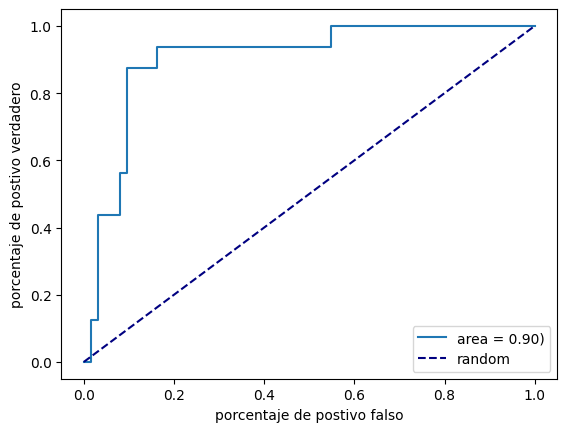

In [109]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
print(accuracy_score(testY, predictions))
falso_positivo, verdad_postivo, threshold = roc_curve(testY, mlp.predict_proba(testx_promedio)[:, 1])
plt.step(falso_positivo, verdad_postivo, label="area = {1:0.2f})".format(i, auc(falso_positivo, verdad_postivo)))
plt.xlabel("porcentaje de postivo falso")
plt.ylabel("porcentaje de postivo verdadero")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label='random')
plt.legend()